In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.8.0'

# 6.2 주요 레이어 정리

24576/15922 [==============================================] - 0s 1us/step


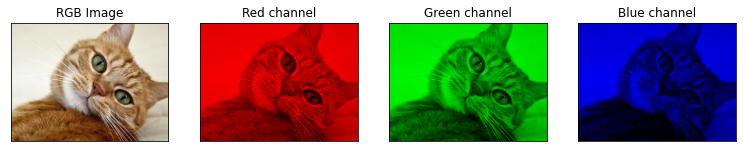

In [3]:
# 목적 : 이미지 데이터의 Chanel에 대한 정보 확인!!

# 그림 6.8 출력 코드. 참고 링크 : https://stackoverflow.com/a/37435090/2689257
import matplotlib.pyplot as plt

image_path = tf.keras.utils.get_file('cat.jpg', 'http://bit.ly/33U6mH9')
image = plt.imread(image_path)

titles = ['RGB Image', 'Red channel', 'Green channel', 'Blue channel']
cmaps = [None, plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r]

from numpy import array, zeros_like
def channel(image, color):
    if color not in (0, 1, 2): return image
    c = image[..., color]
    z = zeros_like(c)
    return array([(c, z, z), (z, c, z), (z, z, c)][color]).transpose(1,2,0)
  
colors = range(-1, 3)
fig, axes = plt.subplots(1, 4, figsize=(13,3))
objs = zip(axes, titles, colors)
for ax, title, color in objs:
    ax.imshow(channel(image, color))
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

In [4]:
# 6.1 Conv2D 레이어 생성 코드
# kernel_size : 필터 행렬 크기
# strides : 필터가 계산 과정에서 한 스텝마다 이동
#           --> 2D에서 이동을 하니, 가로step,세로step
# padding : valid 는 유효한 것만 --> 크기 줄어들게 됨
#           same 는 출력크기를 입력과 동일하게 세팅!!!
# filters : 사용할 필터의 수!!!!!
conv1 = tf.keras.layers.Conv2D( kernel_size = (3,3),
                                strides = (2,2),
                                padding = "valid",
                                filters = 6
    )

In [5]:
# 6.2 MaxPool2D 레이어 생성 코드
# pool_size : 한 번에 Max 연산을 수행할 범위!!
# strides : 위의 설명과 동일!!!
pool1 = tf.keras.layers.MaxPool2D( pool_size = (2,2),
                                   strides = (2,2)
    )

In [6]:
# 6.3 Dropout 레이어 생성 코드
# rate : 제외할 뉴런의 비율!!!
pool1 = tf.keras.layers.Dropout( rate = 0.3)

# 6.3 Fashion MNIST with CNN

In [7]:
# 6.4 Fashion MNIST 데이터셋 불러오기 및 정규화

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_X, train_Y), (test_X, test_Y) = fashion_mnist.load_data()

train_X = train_X / 255.0
test_X = test_X / 255.0

In [8]:
# 일단 이 경우는 흑백으로 chanel은 없음!!
# 28 by 28 이미지가 60000장 쌓여 있음!!!!
train_X.shape

(60000, 28, 28)

In [ ]:
# 주어진 데이터는 명확하게 2D로 받게 되었음
# ---> 이거 3D로 흑백이지만, (28,28,1) ---> conv에 태울 수 있다
train_X[0].shape

(28, 28)

참고 : reshape에서 -1의 사용법 --> 고정된 상태에서 남은 것을 유동적으로
<img src="https://drive.google.com/uc?id=
1II877on4j4Z1hO3HMqoT5WBDeKJ49tUV">

In [9]:
# 6.5 데이터를 채널을 가진 이미지 형태(3차원)으로 바꾸기
# reshape 이전
print(train_X.shape, test_X.shape)

##############################################
# 중요!!!!) channel이 1개가 있는 것이라 하고,
#           2D 이미지 데이터 -> 3D chanel 차원 추가
#           기존의 데이터 6만장 쌓고..
#           최종 4D로 형성됨!!!!!!! 
# 이 부분에 대한 변형을 정확히 인지해야함!!!!!!!
# 나중에 이러한 사소한 부분에서 실수 발생함!!!!
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape( -1, 28, 28, 1)
#############################################

# reshape 이후
print(train_X.shape, test_X.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


<img src="https://drive.google.com/uc?id=1GjA4w1c8v00YaYFRqm9PpBXaBTx-UwEh">

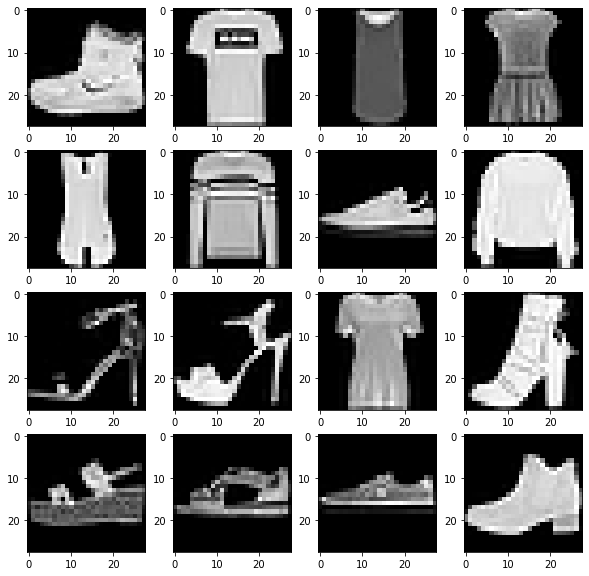

[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9]


In [10]:
# 6.6 데이터 확인
import matplotlib.pyplot as plt
# 전체 그래프의 사이즈를 width=10, height=10 으로 지정합니다.
plt.figure(figsize=(10, 10))
for c in range(16):
    # 4행 4열로 지정한 grid 에서 c+1 번째의 칸에 그래프를 그립니다. 1~16 번째 칸을 채우게 됩니다.
    plt.subplot(4,4,c+1)
    plt.imshow(train_X[c].reshape(28,28), cmap='gray')
    
plt.show()

# train 데이터의 첫번째 ~ 16번째 까지의 라벨을 프린트합니다.
print(train_Y[:16])

In [13]:
# 6.7 Fashion MNIST 분류 컨볼루션 신경망 모델 정의

# 주의!! 입력 레이어 설계는 늘 1개 데이터에 대해서 생각하고 설계
# 단, 1개 데이터에 대해서 입력은 3D로 chanel을 고려해서 모양 맞추기! 설계는 주로 2D로 chanel을 tf가 알아서 하도록 2D로 설계
#     차원에 대한 혼동 없어야 함
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D( input_shape = (28, 28, 1), kernel_size = (3,3), filters = 16),
        tf.keras.layers.Conv2D( kernel_size = (3,3), filters = 32),
        tf.keras.layers.Conv2D( kernel_size = (3,3), filters = 64),
        # 끝났으니 이제 분류 모델로 넘겨야 하는데 -> 펴야죠
        tf.keras.layers.Flatten(),
        # 뒤에는 일반적인 DNN분류 모델로 설계
        tf.keras.layers.Dense( units = 128, activation = "relu"),
        # 내 분류에 대한 출력단 설계 -> 몇 개로 분류, activationfunc
        tf.keras.layers.Dense( units = 10, activation = "softmax") # units = 10으로 고정 -> 분류모델 10개
]
)

model.compile( metrics = ["accuracy"], 
               loss = "sparse_categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam()
               )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 30976)             0         
                                                                 
 dense (Dense)               (None, 128)               3965056   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 3,989,642
Trainable params: 3,989,642
Non-

Epoch 1/25
1407/1407 [==============================] - 53s 37ms/step - loss: 0.4643 - accuracy: 0.8358 - val_loss: 0.4086 - val_accuracy: 0.8494
Epoch 2/25
1407/1407 [==============================] - 51s 37ms/step - loss: 0.3403 - accuracy: 0.8756 - val_loss: 0.3743 - val_accuracy: 0.8645
Epoch 3/25
1407/1407 [==============================] - 51s 37ms/step - loss: 0.2849 - accuracy: 0.8945 - val_loss: 0.3643 - val_accuracy: 0.8728
Epoch 4/25
1407/1407 [==============================] - 53s 38ms/step - loss: 0.2459 - accuracy: 0.9105 - val_loss: 0.3857 - val_accuracy: 0.8738
Epoch 5/25
1407/1407 [==============================] - 52s 37ms/step - loss: 0.2098 - accuracy: 0.9225 - val_loss: 0.4000 - val_accuracy: 0.8766
Epoch 6/25
1407/1407 [==============================] - 56s 40ms/step - loss: 0.1850 - accuracy: 0.9308 - val_loss: 0.5081 - val_accuracy: 0.8613
Epoch 7/25
1407/1407 [==============================] - 57s 41ms/step - loss: 0.1650 - accuracy: 0.9384 - val_loss: 0.4963 -

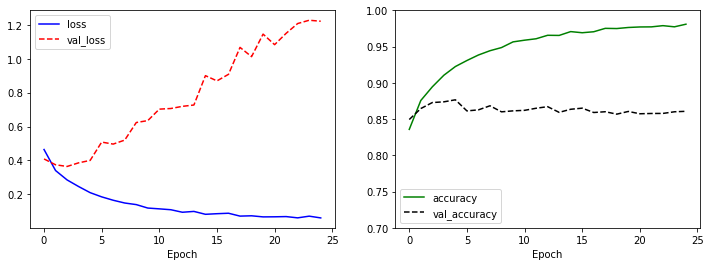

[1.285827398300171, 0.8557999730110168]

In [14]:
# 6.9 Fashion MNIST 분류 컨볼루션 신경망 모델 학습
# history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)
# 위에 너무 오래걸려서리;;;;;GPU없이는..
# conv를 사용을 안 한 앞의 경우들은 오히려 빨라도 conv 부터는...
# colab이 아무리 안 좋은 거라해도..차이가 무지무지 많이 남;;ㅠㅠ
# -> train_X : (60000, 28, 28, 1) 4D
# ---> input_shape : (28, 28, 1) 3D
# ---> Conv2D : 뒤에 채널을 신경 안 쓰고 오로지 가로, 세로만~~~ (n,m)
history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

model.evaluate(test_X, test_Y, verbose=0)

Overfitting이 이루어진 것을 볼 수 있음--> val은 성능이 나빠짐;;;;;;train만 좋아지고 있음..
<img src="https://drive.google.com/uc?id=1bIjPHQiy0kJkzMhYoMlvW81-f-Xgbhw1">

In [15]:
# 6.10 Fashion MNIST 분류 컨볼루션 신경망 모델 정의 - 풀링 레이어, 드랍아웃 레이어 추가

# 위의 overfit한 상황을 해결을 하기 위해서 
# 적당히 연결을 제거하는 Dropout을 활용해보자~~~
model = tf.keras.Sequential(
    [   # 특징 추출을 위한 Conv Layer
        tf.keras.layers.Conv2D( input_shape = (28,28,1), kernel_size=(3,3), filters=32, activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D( kernel_size=(3,3), filters=64, activation = "relu", padding = "same"),
        
        tf.keras.layers.MaxPool2D( pool_size = (2,2)),
        tf.keras.layers.Dropout(rate = 0.5),
        
        tf.keras.layers.Conv2D( kernel_size=(3,3), filters=128, activation = "relu", padding = "same"),
        tf.keras.layers.Conv2D( kernel_size=(3,3), filters=256, activation = "relu", padding = "valid"),
        
        tf.keras.layers.MaxPool2D( pool_size = (2,2)),
        tf.keras.layers.Dropout(rate = 0.5),
        
        # 끝났으니, 이제 분류 모델로 넘겨야 하는데,,,--> 펴야죠!!!!!
        tf.keras.layers.Flatten(),
        # 뒤에는 일반적인 DNN 분류 모델로 설계!!!!!!
        tf.keras.layers.Dense(units = 512, activation="relu"),
        tf.keras.layers.Dropout(rate = 0.5),
        tf.keras.layers.Dense(units = 256, activation="relu"),
        tf.keras.layers.Dropout(rate = 0.5),

        # 내 분류에 대한 출력단 설계!!!! --> 몇 개로 분류, activationfunc
        tf.keras.layers.Dense(units = 10, activation="softmax")
    ]
)
model.compile(metrics = ["accuracy"], 
              loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam())

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 256)       295168    
                                                      

Epoch 1/25
2110/2110 [==============================] - 178s 84ms/step - loss: 0.2585 - accuracy: 0.9093 - val_loss: 0.3980 - val_accuracy: 0.8536
Epoch 2/25
2110/2110 [==============================] - 177s 84ms/step - loss: 0.2583 - accuracy: 0.9093 - val_loss: 0.3749 - val_accuracy: 0.8629
Epoch 3/25
2110/2110 [==============================] - 175s 83ms/step - loss: 0.2592 - accuracy: 0.9087 - val_loss: 0.3912 - val_accuracy: 0.8616
Epoch 4/25
2110/2110 [==============================] - 177s 84ms/step - loss: 0.2578 - accuracy: 0.9093 - val_loss: 0.3934 - val_accuracy: 0.8610
Epoch 5/25
2110/2110 [==============================] - 178s 84ms/step - loss: 0.2567 - accuracy: 0.9098 - val_loss: 0.4466 - val_accuracy: 0.8300
Epoch 6/25
2110/2110 [==============================] - 178s 84ms/step - loss: 0.2619 - accuracy: 0.9070 - val_loss: 0.3985 - val_accuracy: 0.8608
Epoch 7/25
2110/2110 [==============================] - 178s 84ms/step - loss: 0.2590 - accuracy: 0.9090 - val_loss: 0

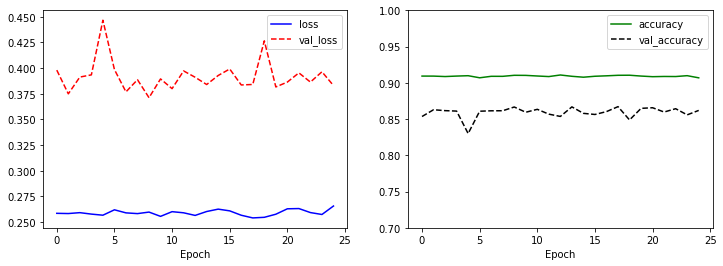

[0.21536247432231903, 0.9240999817848206]

In [26]:
# 6.11 Fashion MNIST 분류 컨볼루션 신경망 모델 학습 - 풀링 레이어, 드랍아웃 레이어 추가
#history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)
history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)


import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

model.evaluate(test_X, test_Y, verbose=0)

<img src="https://drive.google.com/uc?id=1WwW-3CBMlhZa7fKdD1y-jiHCVYO4-FsB">

# 6.4 퍼포먼스 높이기 : 대표적인 방법이    
    - 레이어 더 쌓기 or 보상 구조 추가 등
    - 이미지 보강 : Image Augmentaion

### 6.4.1 ) 레이어 보강하기!!!

<img src="https://drive.google.com/uc?id=1nhFzpY-Bqy-1fSfwGkIWsH9VejHC-Qw9">

In [ ]:
# 6.12 VGGNet 스타일의 Fashion MNIST 분류 컨볼루션 신경망 모델 정의
model = ~

model.compile(~)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 256)       295168    
                                                      

Epoch 1/25
1407/1407 [==============================] - 27s 18ms/step - loss: 0.5802 - accuracy: 0.7890 - val_loss: 0.3276 - val_accuracy: 0.8749
Epoch 2/25
1407/1407 [==============================] - 28s 20ms/step - loss: 0.3639 - accuracy: 0.8687 - val_loss: 0.2928 - val_accuracy: 0.8926
Epoch 3/25
1407/1407 [==============================] - 28s 20ms/step - loss: 0.3215 - accuracy: 0.8842 - val_loss: 0.2891 - val_accuracy: 0.8948
Epoch 4/25
1407/1407 [==============================] - 25s 18ms/step - loss: 0.3042 - accuracy: 0.8914 - val_loss: 0.2313 - val_accuracy: 0.9144
Epoch 5/25
1407/1407 [==============================] - 25s 18ms/step - loss: 0.2850 - accuracy: 0.8975 - val_loss: 0.2290 - val_accuracy: 0.9154
Epoch 6/25
1407/1407 [==============================] - 25s 18ms/step - loss: 0.2779 - accuracy: 0.9027 - val_loss: 0.2265 - val_accuracy: 0.9170
Epoch 7/25
1407/1407 [==============================] - 28s 20ms/step - loss: 0.2655 - accuracy: 0.9049 - val_loss: 0.2536 -

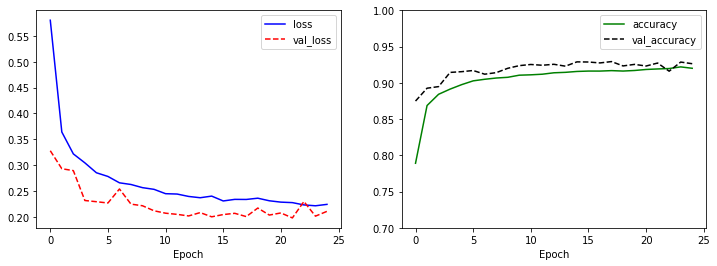

[0.23025739192962646, 0.9223999977111816]

In [ ]:
# 6.13 VGGNet 스타일의 Fashion MNIST 분류 컨볼루션 신경망 모델 학습
#history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)
history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)


import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

model.evaluate(test_X, test_Y, verbose=0)

### 6.4.2) 이미지 추가( Image Augmentation )   
    - 주된 방식은 뒤집기, 회전, 기울이기,확대 축소, 평행이동 등..

ValueError: cannot reshape array of size 28 into shape (28,28)

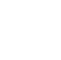

In [24]:
from inspect import Arguments
# 6.14 Image Augmentation 데이터 표시
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 이 ImageDataGenerator 코드 부분은 다음 링크에서 참조했습니다. 
# https://github.com/franneck94/MNIST-Data-Augmentation/blob/master/mnist.py
# rotation, zoom, shift, flip 등을 지정합니다.
image_generator = ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.10,
            shear_range=0.5,
            width_shift_range=0.10,
            height_shift_range=0.10,
            horizontal_flip=True,
            vertical_flip=False)

argument_size = 100

######
x_argumented = image_generator.flow( np.tile(train_X[0].reshape(28*28),100).reshape(-1,28,28,1),
                                   batch_size = argument_size, 
                                   shuffle=False).next()[0]
######

# 새롭게 생성된 이미지 표시
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for c in range(100):
    plt.subplot(10,10,c+1)
    plt.axis('off')
    plt.imshow(x_argumented[c].reshape(28,28), cmap='gray')
plt.show()

In [21]:
# 6.15 Image Augmentation
image_generator = ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.10,
            shear_range=0.5,
            width_shift_range=0.10,
            height_shift_range=0.10,
            horizontal_flip=True,
            vertical_flip=False)

# 훈련 데이터의 50%인 약 3만장 세팅
augment_size = 30000
# 변형할 3만장의 대상 랜덤 선택
randidx = np.random.randint(train_X.shape[0], size=augment_size)


x_augmented = train_X[randidx].copy()
y_augmented = train_Y[randidx].copy()
x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),
                                   batch_size=augment_size, shuffle=False).next()[0]

# 원래 데이터인 x_train 에 Image Augmentation 된 x_augmented 를 추가합니다.
# pandas의 concate와 유사함..
train_X = np.concatenate((train_X, x_augmented))
train_Y = np.concatenate((train_Y, y_augmented))

print(train_X.shape)

(90000, 28, 28, 1)


Epoch 1/25
2110/2110 [==============================] - 180s 85ms/step - loss: 0.5820 - accuracy: 0.7859 - val_loss: 0.5804 - val_accuracy: 0.7758
Epoch 2/25
2110/2110 [==============================] - 182s 86ms/step - loss: 0.3865 - accuracy: 0.8591 - val_loss: 0.5132 - val_accuracy: 0.8085
Epoch 3/25
2110/2110 [==============================] - 179s 85ms/step - loss: 0.3498 - accuracy: 0.8746 - val_loss: 0.4963 - val_accuracy: 0.8137
Epoch 4/25
2110/2110 [==============================] - 179s 85ms/step - loss: 0.3299 - accuracy: 0.8816 - val_loss: 0.4539 - val_accuracy: 0.8277
Epoch 5/25
2110/2110 [==============================] - 178s 85ms/step - loss: 0.3099 - accuracy: 0.8880 - val_loss: 0.4181 - val_accuracy: 0.8488
Epoch 6/25
2110/2110 [==============================] - 177s 84ms/step - loss: 0.3014 - accuracy: 0.8915 - val_loss: 0.4024 - val_accuracy: 0.8519
Epoch 7/25
2110/2110 [==============================] - 176s 84ms/step - loss: 0.2947 - accuracy: 0.8937 - val_loss: 0

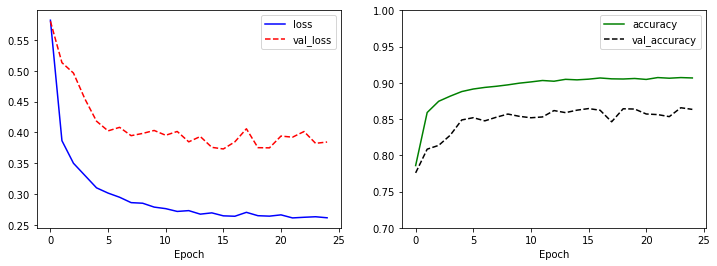

[0.21495652198791504, 0.9232000112533569]

In [25]:
# 6.16 VGGNet style 네트워크 + Image Augmentation 학습
model = tf.keras.Sequential(
    [   # 특징 추출을 위한 Conv Layer
        tf.keras.layers.Conv2D( input_shape = (28,28,1), kernel_size=(3,3), filters=32, 
                               activation="relu", padding="same"),
        tf.keras.layers.Conv2D( kernel_size=(3,3), filters=64,activation="relu", padding="same" ),
        
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(rate=0.5),

        tf.keras.layers.Conv2D( kernel_size=(3,3), filters=128, padding="same", activation="relu"),
        tf.keras.layers.Conv2D( kernel_size=(3,3), filters=256, padding="valid", activation="relu"),
        
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(rate=0.5),
        
        # 끝났으니, 이제 분류 모델로 넘겨야 하는데,,,--> 펴야죠!!!!!
        tf.keras.layers.Flatten(),
        # 뒤에는 일반적인 DNN 분류 모델로 설계!!!!!!
        tf.keras.layers.Dense(units = 512, activation="relu"),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units = 256, activation="relu"),
        tf.keras.layers.Dropout(rate=0.5),
        # 내 분류에 대한 출력단 설계!!!! --> 몇 개로 분류, activationfunc
        tf.keras.layers.Dense(units = 10, activation="softmax")
    ]
)
model.compile(metrics = ["accuracy"], 
              loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam())

#history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)
history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

model.evaluate(test_X, test_Y, verbose=0)

앞의 두 결과에 대한 비교
<img src="https://drive.google.com/uc?id=1ahMCNMh6el92n7tffr1F4QAX0hBMRxQy">
<img src="https://drive.google.com/uc?id=1izscDlCmGkY2RJx9e0jKllEGT_lx1MT7">